<a href="https://colab.research.google.com/github/octavianosilva/data_science/blob/main/Detec%C3%A7%C3%A3o_de_Fake_News_com_Redes_Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News

<center><img alt='Fake News'  src='https://www.meioemensagem.com.br/wp-content/uploads/2020/03/fakenews_Cred-sorbetto-iStock.jpg'></center>

Criador: sorbetto 
| 
Crédito: Getty Images

Um dos principais aspectos da atual Era Digital é a tsunami de informações que nos atingem diariamente e com cada vez mais acessibilidade à elas, fica cada vez mais difícil identificar quais são reais ou falsas.

Dificilmente você não ouviu falar de casos envolvendo Fake News no âmbito político ou econômico ao seu redor, afinal hoje o que mais se fala nas mídias são sobre essas Fake News, que são capazes de desestruturar grandes empresas e até mesmo governos.

Um exemplo bastante próximo da atualidade são os impactos das Fake News envolvendo a pandemia do Corona Vírus, onde elas impactaram a consciência coletiva de várias sociedades, levando várias pessoas à ignorarem medidas de proteção contra o vírus ou a disseminar o medo entre as populações. Dessa forma, Fakes News são altamente destrutivas independentes de onde são disseminadas, o que se faz bastante necessário termos meios para lidar com essas informações.

Com as grandes evoluções tecnológicas que vêm acontecendo e com o avanço na área de Machine Learning (Aprendizado de Máquina), hoje temos as redes neurais que são capazes de simular o cérebro humano com bastante precisão sendo aplicadas em diversas tarefas como: Reconhecimento Facial, Análises de Sentimentos, Localização de Documentos Relevantes, entre várias outras tarefas.

O uso dessas redes neurais são características de Deep Learning (Aprendizado Profundo), e dentro deste aprendizado temos o Processamento de Linguagem Natural (NLP na sigla em inglês - Natural Language Processing) para lidar com dados em textos, e é com base nesse processo que iremos iniciar um projeto para desenvolver um modelo de Deep Learning capaz de detectar as perigosas Fake News.


# Importando os Dados e as Bibliotecas

Os dados que usaremos neste projeto se encontram disponíveis para uso público no [Kaggle](https://www.kaggle.com/saratchendra/fake-news), disponibilizados por [Sarat Chendra](https://www.kaggle.com/saratchendra).

Um detalhe importante é que os dados se encontram todos em inglês, mas não desanime caso não seja familiar com essa língua, ainda será possível acompanhar as etapas deste projeto.



In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm

# Importando a biblioteca das redes neurais
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Importando a visualização de Word Clouds
from wordcloud import WordCloud, STOPWORDS

# Importando os módulos para tratamento e pré-processamento de textos (strings)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.initializers as Init
from sklearn.metrics import classification_report

# Importando o módulo para tratamento de Stop Words e Lemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importando a biblioteca para a vetorização das palavras
import gensim

# Importando o módulo de separação entre dados de treino e teste
from sklearn.model_selection import train_test_split

# Ignorando as mensagens de alertas futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Replicabilidade
np.random.seed(50)

# Importando o dataset do Kaggle
df_raw = pd.read_csv('fake_train.csv')

# Executando o TQDM para termos visualizações de progressos em barras
tqdm.pandas()

# Análise Exploratória

Antes de desenvolvermos um modelo de redes neurais para detectar as notícias falsas, devemos avaliar a qualidade dos dados que foram importados, sendo assim vamos iniciar o projeto checando o tamanho do dataset:

In [2]:
# Checando o tamanho do dataset
df_raw.shape

(20800, 5)

O dataset importado possui 20.800 entradas e 5 colunas.

Podemos ver esses dados estruturados em um DataFrame:

In [3]:
# Checando as primeiras entradas do dataset importado
df_raw.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Temos as colunas:
* `id`: referente a identificação da entrada;
* `title`: ao título da notícia;
* `author`: ao nome do autor da notícia;
* `text`: ao conteúdo da notícia;
* `label`: a classificação da notícia, se é verdadeira (valor 0) ou falsa (valor 1).

Olhando o DataFrame já percebemos que a coluna `id` acompanha os mesmos valores dos índex das entradas, ou seja, temos uma coluna "duplicada" e que não retorna nenhuma informação, então vamos remover essa coluna em um etapa que chamaremos de Tratamento de Dados.

Vamos nos aprofundar nos dados e checar a ocorrência de valores ausentes:

In [4]:
# Checando a ocorrência de valores ausentes (NaN)
df_raw.isnull().sum().sort_values(ascending=False)

author    1957
title      558
text        39
label        0
id           0
dtype: int64

Temos a ocorrência de valores ausentes em quase todas as colunas do dataset, sendo assim precisamos lidar com esses dados para termos um bom desempenho do modelo.

Deixaremos esses tratamentos para uma etapa própria, dessa forma podemos avançar com a análise exploratória.

Vamos checar o balanceamento entre as classes das notícias através da coluna alvo `label`:

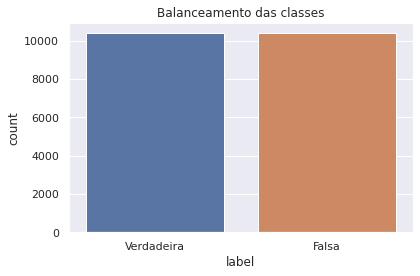

In [5]:
# Setando o tema do gráfico para o seaborn
sns.set_theme()

# Plotando o countplot para a coluna alvo label
fig, ax = plt.subplots()

sns.countplot(df_raw.label).set_title('Balanceamento das classes')
plt.xticks([0,1],['Verdadeira','Falsa'])

plt.tight_layout();

Pelo gráfico vemos que as classes de notícias estão balanceadas, o que é muito bom para o modelo.

Podemos também fazer uma pesquisa pelas palavras que mais aparecem para ambas as classes, esse método é chamado de Word Cloud (Nuvem de Palavras).

Simplesmente jogar as palavras com maior frequência nas notícias sem um tratamento prévio seria bem ruim a visualização das palavras, porque quando escrevemos um texto na língua portuguesa, por exemplo, temos várias preposições e pronomes e elas são consideravelmente mais frequentes que qualquer outra palavra relevante.

Esses pronomes e preposições são conhecidos como Stop Words (Palavras de Parada na tradução livre) e elas são responsáveis por expandir consideravelmente a dimensão dos textos.

O pacote Python NLTK (Natural Language Toolkit) possui uma lista dessas Stop Words em 16 línguas diferentes, como nosso dados estão em inglês, devemos passar essa informação ao NLTK.

Vamos então plotar a Word Cloud para os títulos das notícias de ambas as classes: notícias Verdadeiras e Falsas, aplicando a remoção das Stop Words:



In [6]:
# Definindo a língua inglesa para as Stop Words
nltk.download('stopwords')
nltk_STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


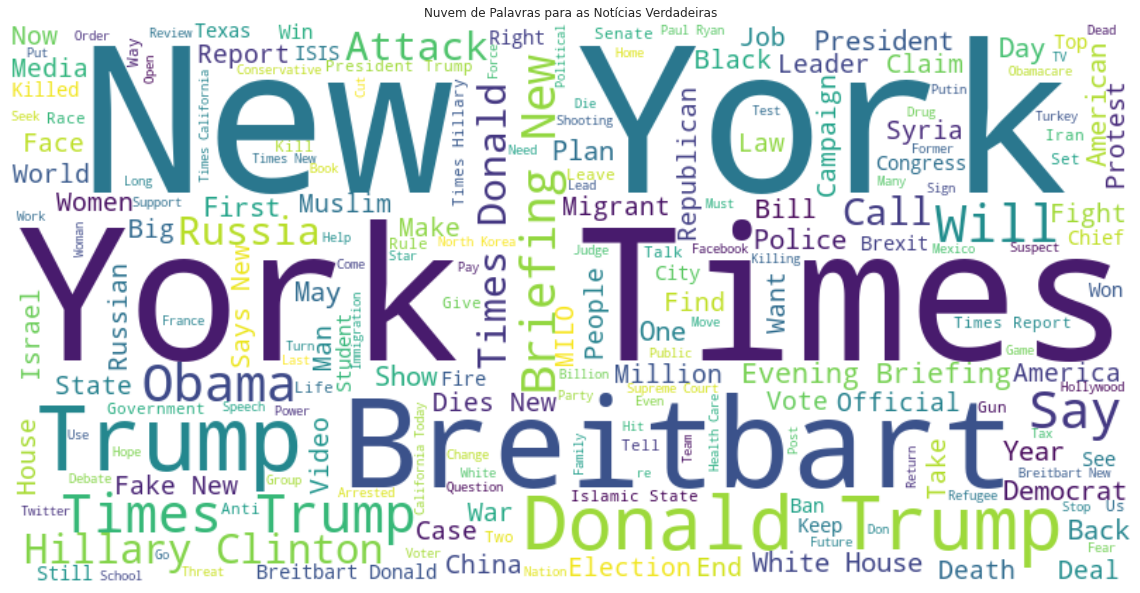

In [7]:
# Separando as palavras em tokens e localizando as que são verdadeiras (label = 0)
texto = " ".join("" if pd.isnull(t) else t for t in df_raw[df_raw['label'] == 0]['title'])

# Plotando a Word Cloud
wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color="white").generate(texto)

fig = plt.figure(figsize=(16, 16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para as Notícias Verdadeiras")

plt.tight_layout();

Agora vamos plotar a Word Cloud para as notícias falsas:

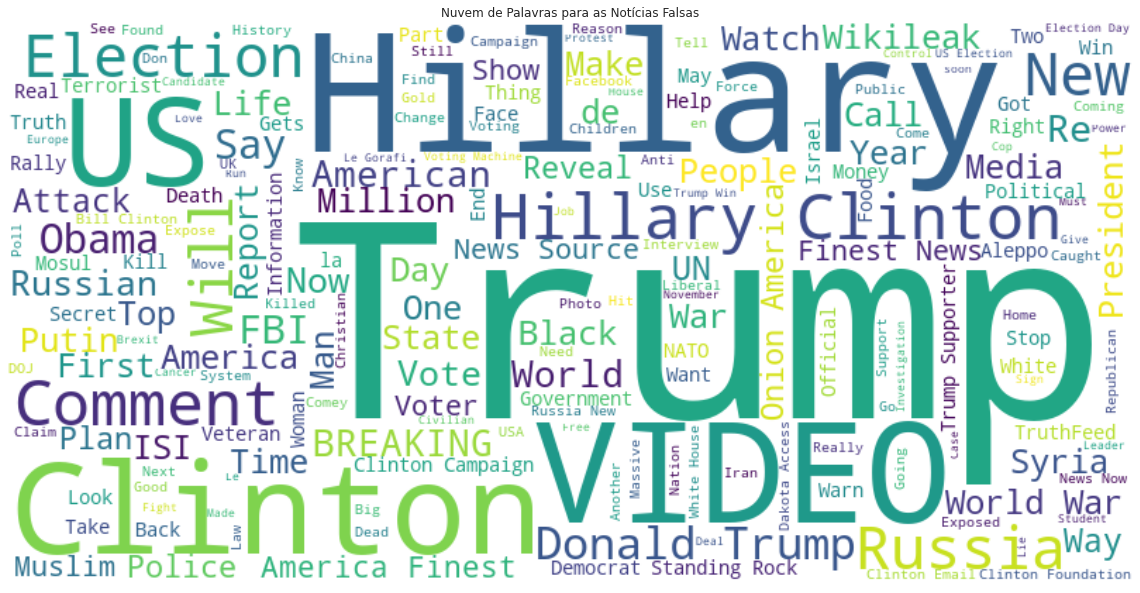

In [8]:
# Separando as palavras em tokens e localizando as que são falsas (label = 1)
texto = " ".join("" if pd.isnull(t) else t for t in df_raw[df_raw['label'] == 1]['title'])

# Plotando a Word Cloud
wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color="white").generate(texto)

fig = plt.figure(figsize=(16, 16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para as Notícias Falsas")

plt.tight_layout();

Interessante notar como as palavras mais frequentes mudaram entre as classes, onde temos que:
* Para as notícias verdadeiras as palavras mais frequentes são: "New York", "York Times" e "Breitbart";
* Já para as notícias falsas, as mais frequentes foram: "Trump", "Hillary" e "Video".
  
Agora que pegamos estes insights, podemos avançar para a etapa de tratamento dos dados, que vimos anteriormente que seria necessário passarmos por ela, entretanto isso não quer dizer que exploramos completamente os dados, por exemplo, poderíamos obter insights com a coluna `author`.

## Tratamento de Dados

Vimos então que temos uma coluna irrelevante para o modelo de detecção e a ocorrência de valores ausentes no dataset, portanto nesta etapa lidaremos com esses problemas.

Primeiramente vamos remover a coluna `id` que é irrelevante:

In [9]:
# Copiando o dataset original para ser tratado
df_clean = df_raw.copy()

# Removendo a coluna id
df_clean.drop(columns='id', inplace=True)

# Checando se houve a remoção
df_clean.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Com a coluna removida vamos avançar para o problema dos valores ausentes, porém antes de aplicarmos qualquer abordagem de tratamento, vamos checar a proporção desses valores em relação ao dataset.

Vamos pegar a coluna `author`, que possui a maior quantidade de valores ausentes, e checar a proporção:

In [10]:
# Checando a proporção dos dados ausentes no dataset
proporcao = df_clean['author'].isnull().sum()/df_clean.shape[0]

print("Proporção dos valores ausentes no dataset: {:.2f}%".format(proporcao))

Proporção dos valores ausentes no dataset: 0.09%


Vemos que esses valores ausentes representam 9% de todo o dataset e por ser uma proporção relativamente baixa, podemos adotar a abordagem de remoção destes valores, pois não seria uma grande perda de informação.

Removendo os valores ausentes:

In [11]:
# Removendo os valores ausentes
df_clean.dropna(inplace=True)

# Checando se houve a remoção
df_clean.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

Como removemos entradas do dataset, podemos ter uma interrupção de index do DataFrame, por exemplo: com a remoção perdemos a entrada de valor 3, então quando olharmos o índex do DataFrame, vemos que da entrada de valor 2 pulamos para a de valor 4.

Dessa forma vamos resetar o índex do DataFrame:

In [12]:
# Resetando o índex do DataFrame
df_clean.reset_index(inplace=True)

# Removendo o antigo index
df_clean.drop(columns='index', inplace=True)

Outro passo importante de ser realizado antes do desenvolvimento de um modelo é a remoção da pontuação no conteúdo das notícias, por exemplo, vamos checar a primeira notícia do DataFrame:

In [13]:
# Checando a primeira notícia do DataFrame
df_clean['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

Como vemos no conteúdo da primeira entrada, temos várias pontuações presentes que precisão ser removidas, além do mais por ser um texto o modelo de redes neurais não é capaz de interpretar esse tipo de entrada.

Assim como a maioria dos modelos de regressão não conseguem interpretar valores do tipo texto (`object`) e precisam que transformemos esse valores para o tipo numérico, o mesmo acontece com os modelos para Processamento de Linguagem Natural (sigla em inglês NLP - Natural Language Processing).

Antes de desenvolvermos o modelo de redes neurais, precisamos ainda passar por outra etapa que é a de pré-processamento dos dados tratados, nela iremos lidar não só com as questões de interpretação e remoção das pontuações, como também abordaremos outras técnicas para melhorarmos a qualidade desses dados que serão utilizados pelo modelo.

# Pré-Processamento dos Dados

Como foi dito acima, para que o modelo possa interpretar um texto precisamos realizar um pré-processamento, que no mesmo pacote do Python que importamos as Stop Words, temos o método conhecido como Tokenização que separa cada palavra no texto em uma lista em tokens, como na figura abaixo:

<center><img alt='Tokenizer'  src='https://github.com/octavianosilva/Imagens_projetos/blob/main/tokenizing.png?raw=true'></center>

Vamos então utilizar essa técnica para deixar os textos legíveis para o modelo:



In [14]:
# Copiando os dados para esta etapa
df_pp = df_clean.copy()

# Realizando a Tokenização
nltk.download('punkt') #intalando o modulo para utilizar progress_apply
df_pp['text_tokens'] = df_pp['text'].progress_apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/18285 [00:00<?, ?it/s]

Agora vamos deixar todas as palavras com letras minúsculas, assim deixamos todas as palavras dos textos "iguais":

In [15]:
# Criando uma função para a redução das letras
def reduzir_letras(tokens):
  return [t.lower() for t in tokens]

# Aplicando a função de redução das letras
df_pp['text_tokens'] = df_pp['text_tokens'].progress_apply(reduzir_letras)

  0%|          | 0/18285 [00:00<?, ?it/s]

Agora vamos voltar para o problema que vimos quando analisamos o conteúdo da primeira notícia do dataset, que era a presença das pontuações. Assim como o processo de Tokenização separa cada palavra, ele também separa as pontuações, dessa forma temos uma grande dimensão de informações irrelevantes.

Iremos então remover essas pontuações dos textos Tokenizados:

In [16]:
# Criando uma função para remover as pontuações
def remover_pontuacao(tokens):
  return [t for t in tokens if t.isalpha()]

# Aplicando a remoção das pontuações
df_pp['text_tokens'] = df_pp['text_tokens'].progress_apply(remover_pontuacao)

  0%|          | 0/18285 [00:00<?, ?it/s]

Quando vimos as Word Clouds (Nuvens de Palavras) durante a Análise Exploratória, discutimos sobre as Stop Words e como elas atrapalhariam na visualização dessas nuvens devido a grande frequência delas nos textos,
e para o modelo elas têm o mesmo efeito que as pontuações, não são informações relevantes e apenas aumentam a dimensionalidade dos dados.

Dito isso, vamos remover essas Stop Words dos textos Tokenizados:

In [17]:
# Criando uma função para remover as Stop Words
def remover_stopwords(tokens):
  return [t for t in tokens if t not in nltk_STOPWORDS]

# Aplicando a remoção das Stop Words
df_pp['text_tokens'] = df_pp['text_tokens'].progress_apply(remover_stopwords)

  0%|          | 0/18285 [00:00<?, ?it/s]

De alguma forma podem aparecer letras soltas que não foram removidas pela remoção das Stop Words ou de outros processos, sendo assim "palavras" irrelevantes e que causam o aumento da dimensão dos dados, para esse caso precisamos remover essas "palavras".

Vamos nos assegurar de não termos essas "palavras" com menos de três letras:

In [18]:
# Criando uma função para remover as palavras com menos de três letras
def remover_palavras_curtas(tokens):
  return [t for t in tokens if len(t) >= 2]

# Aplicando a remoção das palavras com menos de três letras
df_pp['text_tokens'] = df_pp['text_tokens'].progress_apply(remover_palavras_curtas)

  0%|          | 0/18285 [00:00<?, ?it/s]

Outra técnica importante para aplicarmos nesta etapa de pré-processamento é a remocação da redundância de palavras com as mesmas origens, por exemplo para "Programa" temos:
* Programador;
* Programando;
* Programas;
* Programadores;

Para realizarmos essa normalização das palavras, temos as técnicas `Stemmer` e `Lemmatization`.

Ambas essas técnicas geram palavras-raízes para as que são semelhantes, porém a `Stemmer` gera palavras-raízes que podem não existir gramaticalmente, sendo assim necessário se atentar a dois possíveis problemas conhecidos como:

* **Overstemming:** ocorre quando duas palavras são processadas para uma mesma palavra raiz, mas que na verdade têm origens diferentes, por exemplo: as palavras "Cachorros", "Cachoeiras" e "Cachos" são processadas e se tornam "Cacho";

* **Understemming:** ocorre quando duas palavras possuem a mesma raiz mas de alguma forma são geradas duas diferentes.

A técnica `Stemmer` é usada principalmente para indexar documentos em mecanismos de pesquisas de forma interna, uma vez que se usado por trás dos panos, os usuários do mecanismo não veriam essas palavras inválidas. Em todo caso, esse tipo de processamento na maioria dos casos é positivo, uma vez que na maioria das vezes as palavras espelhadas ou derivadas têm o mesmo significado.

Já a técnica `Lemmatization`, podemos dizer que é uma evolução da `Stemmer`, pois esta técnica gera palavras-raízes com base em palavras reais presentes no dicionário. Dessa forma é uma técnica mais complexa e mais lenta que a `Stemmer`, embora forneça melhores resultados ao realizar uma análise que depende da classe gramatical da palavra.

Abaixo vemos uma comparação das palavras-raízes que são geradas por ambas as técnicas:

<center><img alt='StemmingvsLemmatization'  src='https://www.baeldung.com/wp-content/uploads/sites/4/2020/06/stemvslemma.png'></center>

FONTE: [Francesco Elia em seu artigo no site Baeldung: Stemming vs Lemmatization](https://www.baeldung.com/cs/stemming-vs-lemmatization)


Como nosso foco não é em desempenho do modelo, vamos adotar a técnica `Lemmatization`:

In [19]:
# Instanciando o Lemmatizer
lemme = WordNetLemmatizer()
nltk.download('wordnet')

# Criando uma função para a normalização das palavras redundantes
def lematize(tokens, lematizer):
  tokens = [lematizer.lemmatize(t, pos = "v") for t in tokens]
  return [lematizer.lemmatize(t, pos = "n") for t in tokens]

# Aplicando o Lemmatizer
df_pp['text_tokens'] = df_pp['text_tokens'].progress_apply(lambda tokens: lematize(tokens, lemme))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/18285 [00:00<?, ?it/s]

Redes neurais precisam de entradas vetorizadas e padronizadas para conseguir interpretar os dados. Dito isso devemos então, vetorizar nossos dados e deixá-los com as mesmas dimensões, e para isso temos uma biblioteca Python chamada `Gensim`.

Essa biblioteca é responsável por criar os vetores de palavras e embora esse processo possa ser realizado através do próprio `Keras`, `Gensim` possui mais funcionalidades e configurações.

In [20]:
# Aplicando a vetorização das palavras
model_word2vec = gensim.models.Word2Vec(sentences= df_pp['text_tokens'], #passamos a lista de palavras, que no nosso caso é a coluna text_tokens
                                        size= 100, #passamos a dimensão dos vetores, vamos adotar 100 dimensões para este caso
                                        window= 7, #refere-se a distância em que as palavras são correlacionadas, para manter sentidos em frases vamos colocar o valor em 7
                                        workers= 2, #são a quantidade de threads necessárias para executar o treinamento do vetor
                                        min_count= 1) #refere-se à frequência das palavras no vetor, palavras com frequências abaixo do valor que for informado são ignoradas

Agora que temos a vetorização das palavras treinada, vamos definir o tamanho do vocabulário para os vetores:

In [21]:
# Definindo o tamanho do vocabulário dos vetores
tamanho_vocab = len(model_word2vec.wv.vocab)

# Checando o tamanho do vocabulário
tamanho_vocab

128824

Interessante que utilizando a biblioteca `Gensim`, podemos checar a relação de similaridade de palavras, como por exemplo para a palavra "person" (Pessoa em português):

In [22]:
# Checando a relação de similaridade
model_word2vec.wv.most_similar("person")

[('someone', 0.7094070315361023),
 ('people', 0.6002292633056641),
 ('individual', 0.597457766532898),
 ('anyone', 0.5879945158958435),
 ('circumstance', 0.5837446451187134),
 ('man', 0.5796493291854858),
 ('everyone', 0.5693584680557251),
 ('reasonably', 0.5642019510269165),
 ('thing', 0.5606831312179565),
 ('somebody', 0.5544182658195496)]

Apesar de todos esses tratamentos e processos realizados até agora, ainda precisamos sequenciar as palavras que estão nos vetores, por exemplo vamos pegar o vetor Tokenizado da frase "O rato roeu a roupa do rei de Roma", temos o vetor ["O" , "rato" , "roeu" , ...] e realizando o sequenciamento nesse vetor temos [1, 2, 3, ...]. Vale lembrar que o valor [0] é reservado para o `Padding`.

A técnica `Padding` é um procedimento para deixar todas as sequencias de dados de entrada com o mesmo comprimento, utilizando tanto o preenchimento ou o truncamento dos dados para esse fim. Esse processo é necessário, pois como foi dito anteriormente, modelos com base em redes neurais precisam que os dados de entrada sejam padronizados.

Primeiro vamos realizar o sequenciamento dos vetores de palavras utilizando o método `Tokenier`, este é diferente do `Word Tokenizer` que usamos para separar cada palavra do texto no inicio desta etapa.

Esse método `Tokenier` é responsável por sequenciar os vetores em valores numéricos:

In [23]:
# Instanciando o Tokenizer
token = Tokenizer()
token.fit_on_texts(df_pp['text_tokens'])

# Aplicando a sequenciação dos vetores de palavras
df_pp['text_tokens'] = token.texts_to_sequences(df_pp['text_tokens'])

Agora que os vetores foram sequenciados, precisamos transformar todos esses vetores em uma matriz que sera a entrada para o modelo de redes neurais:

In [24]:
# Aplicando a transformação dos vetores em matriz
words2vec_matrix = np.zeros((tamanho_vocab+1, 100)) #passamos o vocabulário e a dimensão dos vetores, que definimos anteriormente o valor 100

for word, index in tqdm(token.word_index.items()):
    words2vec_matrix[index] = model_word2vec.wv[word]

  0%|          | 0/128824 [00:00<?, ?it/s]

Vamos checar o tamanho dessa matriz:

In [25]:
words2vec_matrix.shape

(128825, 100)

Agora que realizamos a transformação dos vetores, vamos voltar a falar sobre a técnica `Padding`.

Como foi explicado, essa técnica é para padronizar o tamanho das entradas para o modelo de redes neurais, de forma que se temos um vetor sequenciado [1, 2, 3] e outro [1, 2], quando aplicamos essa técnica de padronização, temos que [1, 2] se torna [1, 2, 0], assim preenchendo o espaço para ter o mesmo tamanho de três tokens que [1, 2, 3].

Vamos então aplicar o `Padding` na matriz:

In [26]:
# Obtendo o tamanho máximo das sequencias
MAX_LEN = max([len(x) for x in df_pp['text_tokens']])

# Aplicando o Padding
data = pad_sequences(sequences= df_pp['text_tokens'], #passamos os dados que serão processados pelo padding, que é a coluna text_tokens
                     padding= 'post', #significa que o preenchimento será feito ao fim do vetor, 'pre' para preencher no início
                     maxlen= MAX_LEN, #passamos o comprimento máximo das sequencias
                     dtype= int) #definindo o tipo para numérico

# Separando coluna alvo label
labels = df_pp['label']

Agora que todos os pré-processamentos necessários para podermos alimentar o modelo de redes neurais foram realizados, podemos enfim avançar para a etapa de desenvolvimento do modelo.

# Desenvolvimento do modelo de Deep Learning

Deep Learning quer dizer aprendizado profundo, que nada mais é que a utilização de uma densa rede neural para realizar tarefas similando a inteligência humana.

Quando utilizamos redes neurais, passamos inputs (dados de entrada) que percorrem vários nós interconectados que chamamos de neurônios em camadas conhecidas como Hidden Layers, essas camadas possuem as características que irão fazer com que o modelo decida qual o melhor resultado para determinado dado de entrada, que será apresentado na camada de saída chamada de Output Layer.

Abaixo é possível ver uma representação da estrutura de uma rede neural, onde à esquerda temos um modelo de rede neural simples e à direita um modelo de Deep Learning:

<center><img alt='Deep Learning'  src='https://www.institutodeengenharia.org.br/site/wp-content/uploads/2019/04/2.png'></center>

Caso queira conhecer mais sobre as redes neurais e Deep Learning (Aprendizado Profundo), na Seção de Referências se encontram links para esses assuntos.

Antes de instanciarmos o modelo de redes neurais, devemos realizar a separação entre os dados de treino e teste:




In [27]:
# Copiando o dataset para esta etapa
X = data.copy()
y = labels.copy()

# Separando os dados de treino e teste, sendo o teste referente à 20% do dataset e o treino a 80% do dataset
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size= 0.20)

Vamos checar o tamanho dos datasets para cada conjunto:

In [29]:
# Checando a quantidade de entradas por conjunto
print('Entradas por conjunto:')
print('Conjunto de Treino: ',len(X_treino), 'entradas.')
print('Conjunto de Teste: ', len(X_teste), 'entradas.')

Entradas por conjunto:
Conjunto de Treino:  14628 entradas.
Conjunto de Teste:  3657 entradas.


Como estamos utilizando dados sequenciados, vamos usar o modelo de Machine Learning `Sequential`, nesse modelo temos que nossa camada (layer) mais importante é a `Embedding`, que será usada para cruzar as informações dos vetores de palavras do dataset, e como nossos vetores de palavras já estão treinados, devemos colocar que o parâmetro `trainable` seja `False`.

Para extrair as variáveis do dataset, será usado o método `Conv1D`, e para as camadas ocultas (Hidden Layers) vamos utilizar uma das funções de ativação mais conhecidas, que é a ReLU, e para a camada de saída (Output Layer) vamos utilizar a função Sigmoid, já que nosso problema de detecção é binário: notícia verdadeira ou notícia falsa.

Iremos utilizar o algoritmo de otimização Adam que tem baixo custo computacional e em vários casos é capaz de obter resultados mais rapidamente que outros algoritmos de "Gradient Descent".

Como foi dito que nosso problema é binário, vamos utilizar a métrica de avaliação `binary_crossentropy` para perda e para o desempenho do modelo a acurácia (`accuracy`).

In [31]:
# Instanciando o modelo sequencial
modelo = Models.Sequential()

# Desenvolvendo o modelo
modelo.add(Layers.Embedding(tamanho_vocab+1, #passando o vetor com o tamanho do vocabulário
                            100, #passando a quantidade de dimensões, que definimos que seriam 100
                            embeddings_initializer= Init.Constant(words2vec_matrix), #passando a matriz dos vetores de palavras
                            input_length= MAX_LEN, #passando o tamanho máximo dos dados de entrada
                            trainable=False)) #como os vetores já estão treinados, não vamos realizar novamente esse passo, por isso False

modelo.add(Layers.Conv1D(16, 3, activation='relu'))
modelo.add(Layers.MaxPooling1D(5))
modelo.add(Layers.Conv1D(8,3, activation="relu"))
modelo.add(Layers.Flatten())
modelo.add(Layers.Dense(8,activation='relu'))
modelo.add(Layers.Dropout(0.5))
modelo.add(Layers.Dense(4,activation='relu'))
modelo.add(Layers.Dense(1,activation='sigmoid'))

# Compilando o modelo usando
modelo.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

Agora que temos o modelo pronto, vamos treiná-lo:

In [34]:
# Treinando o modelo e separando os dados de validação em 20% do treino
history = modelo.fit(X_treino, y_treino, batch_size=64, epochs=10, validation_split=0.20)

Epoch 1/10
183/183 [==============================] - 298s 2s/step - loss: 0.5439 - accuracy: 0.7388 - val_loss: 0.3258 - val_accuracy: 0.8749
Epoch 2/10
183/183 [==============================] - 295s 2s/step - loss: 0.4045 - accuracy: 0.8462 - val_loss: 0.2934 - val_accuracy: 0.8722
Epoch 3/10
183/183 [==============================] - 297s 2s/step - loss: 0.3498 - accuracy: 0.8661 - val_loss: 0.2408 - val_accuracy: 0.9074
Epoch 4/10
183/183 [==============================] - 296s 2s/step - loss: 0.3080 - accuracy: 0.8932 - val_loss: 0.2034 - val_accuracy: 0.9279
Epoch 5/10
183/183 [==============================] - 296s 2s/step - loss: 0.2622 - accuracy: 0.9094 - val_loss: 0.2008 - val_accuracy: 0.9173
Epoch 6/10
183/183 [==============================] - 296s 2s/step - loss: 0.2377 - accuracy: 0.9204 - val_loss: 0.1913 - val_accuracy: 0.9279
Epoch 7/10
183/183 [==============================] - 297s 2s/step - loss: 0.2177 - accuracy: 0.9249 - val_loss: 0.1947 - val_accuracy: 0.9327

Depois de 10 épocas de treinamento, nosso modelo obteve os resultados (aproximadamente):
* Para os dados de treino:
 * Acurácia: 94%
 * Perda: 17%
* Para os dados de validação:
 * Acurácia: 93%
 * Perda: 20%

Para termos uma melhor visão do treinamento, vamos plotar um gráfico tanto para a acurácia quanto para a perda em relação às épocas de treinamento:

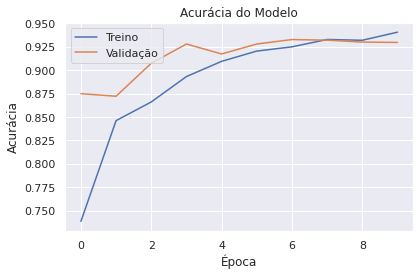

In [35]:
# Plotando o gráfico da relação entre Acurácia e as Épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.tight_layout();

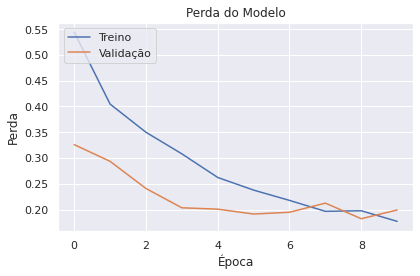

In [37]:
# Plotando o gráfico da relação entre as Perdas e as Épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.tight_layout();

Agora vamos obter o relatório de classificação em cima da previsão dos dados de testes:

In [38]:
# Obtendo o relatório de classificação para os dados de teste
print(classification_report(modelo.predict(X_teste).round(), y_teste))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      2235
         1.0       0.89      0.95      0.92      1422

    accuracy                           0.93      3657
   macro avg       0.93      0.94      0.93      3657
weighted avg       0.94      0.93      0.94      3657



Pelo Relatório de Classificação, temos que nosso modelo obteve a acurácia de 93%, e se olharmos para a métrica F1-Score, que refere-se ao balanceamento entre os falsos positivos e negativos, podemos dizer que como ela está acima de 90% este modelo possui um bom desempenho.

Embora tenhamos obtido um bom desempenho, este modelo ainda pode ser melhorado de diversas formas, como utilizando outros tratamentos e pré-processamentos de dados, e também realizando uma otimização dos hiperparâmetros do modelo utilizado.

# Conclusão

Concluindo nosso projeto de Detecção de Fake News, obtivemos um modelo capaz de detectar as notícias falsas com uma acurácia de 93%, mas vale lembrar novamente que o desempenho deste modelo pode ser melhorado através de outras abordagens.

A metodologia utilizada para realizar as etapas deste projeto não são únicas, por exemplo existem módulos das bibliotecas importadas capazes de realizarem vários processos de uma só vez, como o módulo `PorterStemmer`: que aplica tanto a separação dos textos em tokens, a redução das letras maiúsculas para minúsculas, remove as Stop Words e as redundâncias dos textos. Entretanto para explicar melhor os passos e para que seja fácil de acompanhar o desenvolvimento do projeto, optei por realizar cada pré-processamento separadamente.

Gostaria de fazer uma menção especial ao projeto desenvolvido por [UZAIR KHAN](https://www.kaggle.com/uzairrj) no Kaggle referente ao mesmo banco de dados que foi utilizado neste, onde serviu de guia para várias etapas deste projeto.

Por favor sinta-se à vontade para fazer críticas ou sugestões, seu feedback é bastante importante.

# Referências

Sobre Redes Neurais:
* https://www.sas.com/pt_br/insights/analytics/neural-networks.html

Sobre Deep Learning (Aprendizado Profundo):
* https://www.sas.com/pt_br/insights/analytics/deep-learning.html

Sobre o Tensor Flow:
* https://www.tensorflow.org

Sobre as Stop Words:
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

Sobre a Lemmatization e Stemmer:
* https://www.baeldung.com/cs/stemming-vs-lemmatization

Sobre o Stemming:
* https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
* https://www.geeksforgeeks.org/introduction-to-stemming/

Sobre o Gensim:
* https://radimrehurek.com/gensim/models/word2vec.html

Sobre a técnica Padding:
* https://www.tensorflow.org/guide/keras/masking_and_padding#:~:text=Padding%20is%20a%20special%20form,pad%20or%20truncate%20some%20sequences.

Sobre o modelo sequencial utilizado:
* https://towardsdatascience.com/sequence-models-and-recurrent-neural-networks-rnns-62cadeb4f1e1

Sobre o algoritmo de otimização Adam:
* https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/